# **Ускоряем LLM по максимуму. Как я создал кросс-платформенный Flash Attention с поддержкой Turing+ архитектур и не только**

На сегодняшний день трансформеры правят балом хайпа в мире машинного обучения, особенно после появления ChatGPT и ему подобных языковых моделей. Это стало возможным благодаря лежащему в основе их архитектуры механизму внимания (attention), однако он же и является слабым местом с точки зрения производительности и потребления памяти. Хотя в связи с этим и была разработана изящная концепция Flash Attention (Tri Dao), её существующие реализации имеют ряд ограничений. Поэтому представляю вашему вниманию первую и единственную open-source реализацию Flash Attention 2 на Triton с поддержкой Linux и Windows, Turing-Blackwell архитектур (теперь можно работать в Google Colab и Kaggle), гомо и гетерогенных кластеров, опциональным детерминизмом, а также возможностью ручной кастомизации ядер (kernels) для более гибкой настройки под каждую GPU архитектуру отдельно. Более подробно о том как это устроено и не только — далее в статье.

## **Research engineering: от сложной теории к ещё более сложной практике**

В современном ML существует естественное разделение: исследователи создают новые концепции и проводят над ними эксперименты, а ML-инженеры используют готовые инструменты на их основе в продакшене. Но как создаются такие инструменты? Research engineering как раз занимает уникальное положение, находясь на стыке научных исследований и инженерной практики, а research-инженеры специализируются на реализации сложных математических ML концепций в эффективные и надёжные продакшен решения. Для этого требуется не просто поверхностное знакомство с теорией, а глубокое понимание математических основ и навыки программирования на уровне, значительно превышающем подготовку обычных ML-специалистов.

На практике это означает непрерывное изучение новых научных статей, анализ исходного кода передовых репозиториев, а также множество попыток написать рабочий код и проведение экспериментов, чтобы довести его до приемлемого уровня. Например, продукты вроде PyTorch, Hugging Face, ChatGPT или LangChain как раз создаются research-инженерами. Хотя такие специалисты встречаются гораздо реже и задействованы в основном в топовых компаниях, иногда, как показывает опыт, даже малым бизнесам требуется разработка полностью закрытых и независимых продуктов. Flash Attention 2 на Triton как раз был решением реальной проблемы, когда пришлось адаптировать данный алгоритм под старые GPU и добавить возможность ручной настройки параметров. Одновременно с тем, что подобные open-source проекты могут принести большую пользу ML-сообществу, они служат наглядной демонстрацией того, как research engineering реализуется на практике — именно по этим причинам мне захотелось поделиться чем-то подобным.


## **Устройство GPU: основные моменты**

Производительность GPU в задачах ML по большей части определяется не столько скоростью вычислений (хотя это тоже очень важный аспект), сколько эффективным использованием памяти. Поэтому для лучшего понимания оптимизации механизма внимания, рассмотрим основные компоненты и показатели современной архитектуры Nvidia GPU на примере завода.

**1. Показатели производительности**

- FLOPS (Floating Point Operations Per Second) — теоретически максимальное количество выполняемых операций с плавающей точкой в секунду. Например, если этот показатель составляет 10 TFLOPS, то на GPU может выполняться до 10 триллионов операций в секунду.
- Memory Bandwidth (пропускная способность памяти) — объём данных для операций чтения/записи в различные уровни памяти GPU за единицу времени.
- Latency (задержка) — время от запроса до получения данных из различных уровней памяти GPU.

**2. Streaming Multiprocessors (SM) — цеха завода**

Каждый SM представляет собой автономный производственный модуль, содержащий:

- CUDA-ядра — универсальные станки для базовых операций.
- Tensor cores — специализированные конвейеры для сверхбыстрых операций.
- SRAM и регистры (об этом чуть ниже).

**3. Executors & Schedulers — основные работники**

- Thread (поток) — единичный рабочий, выполняющий элементарные операции.
- Warps (бригады) — группы потоков (обычно 32), выполняющих идентичные операции над разными данными. Любая задержка (например, ожидание данных) останавливает всю группу.
- Warp schedulers (планировщики) — диспетчеры, распределяющие задачи между warps по CUDA-ядрам, чтобы минимизировать их простой.

**4. Иерархия памяти: система складов**

- HBM (High Bandwidth Memory) — главный склад, занимающий основной объём памяти (десятки ГБ), но относительно низкую пропускную способность (~1.5-2.0 ТБ/с) и высокую задержку по сравнению с SRAM.
- L2 кэш — промежуточный буфер между HBM и всеми SM, снижающий число запросов к часто запрашиваемым данным со средней пропускной способностью (~5-7 ТБ/с) и объёмом в несколько десятков МБ.
- SRAM (Static Random-Access Memory) — локальный буфер внутри каждого SM. Имеет небольшой объём (64-256 КБ на SM), но чрезвычайно высокую пропускную способность (~18-20 ТБ/с). Начиная с архитектуры Volta, представляет собой единый физический блок, который состоит из 2-х частей:
  - L1-кэш (аппаратно-управляемая) — автоматически уменьшает задержки доступа данных к L2 и HBM.
  - Shared Memory (программируемая) — используется для явного обмена данными между потоками. Именно данный компонент критически важен для работы Flash Attention.
- Регистры — сверхбыстрая память (~100 ТБ/с), приватная для каждого потока с наименьшим объёмом (обычно составляет 128-256 байт на поток).

**5. Kernel (программное GPU ядро) — технологическая карта**

Kernel — единый набор инструкций для параллельного выполнения потоками на аппаратных ядрах по модели SIMT (Single Instruction, Multiple Threads).

**6. Memory Controller — логистический отдел**

Контроллер памяти — специализированный аппаратный блок, управляющий операциями чтения/записи для определённого сегмента памяти GPU таким образом, чтобы обеспечить для него максимальную пропускную способность и минимальные задержки. Современные GPU имеют несколько таких контроллеров, каждый из которых обслуживает свой собственный канал памяти (memory channel) параллельно.

**7. PCIe & NVLink — магистрали данных**

- PCI Express (Peripheral Component Interconnect Express) — стандартный высокоскоростной канал связи между GPU и CPU, обеспечивающий доступ к системной памяти и управление работой GPU. Является обязательным базовым стандартом для всех конфигураций.

- NVLink (NVIDIA NVLink) — специализированный высокоскоростной канал, позволяющий нескольким GPU обмениваться данными напрямую (peer-to-peer) в обход CPU, что обеспечивает более высокую пропускную способность (в 8-10 раз) и меньшую задержку. Используется как дополнение к PCIe.


## **Vanilla Attention: предпосылки появления и главный недостаток**

Появление механизма внимания обусловлено прямым следствием развития векторных представлений данных и ограниченного потенциала RNN-архитектур для их применения. Рассмотрим эти моменты чуть более подробно.

### **Что такое эмбеддинги и для чего они нужны**

Эмбеддинги — это набор потенциальных признаков в виде обучаемых векторов, необходимый для лучшего описания взаимосвязей между элементами последовательности в n-мерном пространстве. На примере текста это означает векторное представление токенов (слов или частей текста) в пространстве их потенциальных признаков таким образом, чтобы геометрическая близость между этими векторами отражала семантическую и синтаксическую близость соответствующих слов. Проще говоря, эмбеддинги позволяют в пространстве признаков сходным по смыслу токенам располагаться ближе друг к другу, а разным — дальше.

Помимо этого, эмбеддинги могут быть позиционными и прибавляться к эмбеддингам токенов, как это реализовано в трансформерах. Например, после обучения эмбеддинги слов «король» и «королева» будут иметь высокую геометрическую близость (поскольку оба обозначают монархов), но при этом их векторы будут различаться вдоль определённой размерности (условно, «гендерный признак»). Более того, векторная операция «король - мужчина + женщина» даст результат, максимально близкий к вектору «королева», а позиционные эмбеддинги позволят уловить разницу между предложениями «Страной правит король, а не королева» и «Страной правит королева, а не король», что очень важно на практике.

### **Архитектурные ограничения рекуррентных нейронных сетей (RNN)**

Архитектура RNN длительное время считалась стандартом для обработки последовательных данных, в основе которой лежит следующий принцип: на каждом временном шаге $t$ новый элемент поступает на вход сети вместе со скрытым состоянием $H_t$ (hidden state) — компактным векторным представлением всей предыдущей последовательности. Схематично в самом простом виде это можно представить следующим образом:


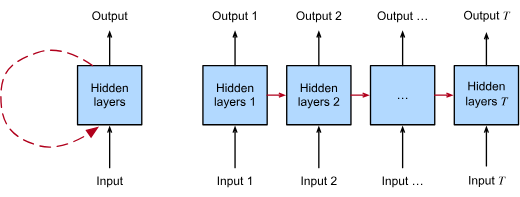

*Источник: D2L book*

Отсюда возникают следующие проблемы:

- Потеря контекста на больших последовательностях. Необходимость сжатия всей истории последовательности в единый вектор фиксированного размера приводит к потере информации из-за её обновления на каждом временном шаге $t$, что также известно как information bottleneck.

- Трудности параллелизма. Поскольку вычисления на каждом временном шаге $t$ начинаются только после полного завершения всех вычислений на предыдущем шаге $t-1$, то это ограничивает возможность параллельных вычислений на GPU, что приводит к их неэффективному использованию. Частичные решения (параллелизация RNN по батчам, временным блокам или слоям) не устраняют проблему в полной мере.

- Нестабильность обучения (взрыв/затухание градиентов). Во время обратного распространения ошибки во времени (Backpropagation Through Time) к RNN необходимо разворачивать (или расширять) вычислительный граф с использованием одних и тех же параметров на каждом временном шаге. При этом градиент по каждому параметру должен быть суммирован по всем местам, где этот параметр встречается в развёрнутой сети. В таком случае, если собственные значения матрицы весов скрытого состояния будут больше либо меньше 1, это приведёт к взрыву/затуханию градиентов соответственно.


### **Теперь про Attention**

Изначально механизм внимания был представлен для задач машинного перевода (Bahdanau et al., 2014), суть которого заключалась в возможности декодера динамически обращаться к различным частям исходного предложения на каждом шаге генерации через вычисление весов внимания, представленных в виде взвешенной суммы энкодерных состояний. Позже данная идея легла в основу самовнимания (self-attention) в трансформерах, где было предложено полностью отказаться от RNN, а также дополнительно использовать 3 линейные проекции (Q, K, V) для входных эмбеддингов. Разберём эту интуицию более подробно на текстовом примере *«She rose (action) from the bed to smell the rose (flower)»*.

Из предложения выше видно, что смысл слова «rose» сильно зависит от контекста: в одном случае оно означает действие, в другом — растение. Получается, что тот самый контекст определяется связью одного слова с другими: с какими-то сильнее, а с какими-то слабее. Следовательно, для определения связи каждого слова друг с другом необходимо как-то вычислить их корреляцию между собой. Логичным и в то же время самым простым способом кажется использование входных эмбеддингов напрямую для определения семантической близости их признаков через скалярное произведение (отражает сонаправленность векторов). В дополнение к этому, если пропустить полученные значения через softmax, то можно получить интерпретируемую матрицу весов внимания: чем ближе значения к единице, тем сильнее связь слов. Проще говоря, такая матрица позволит модели узнать на какие слова стоит обратить больше внимания при обращении к текущему слову. Ну а если перемножить полученные веса на исходные эмбеддинги, то в итоге получатся новые представления токенов (слов), содержащие в себе всю информацию из контекста. Математически это можно представить как:

$$
W_{attn} = softmax(X X^T)
\\ Attention(X) = W_{attn} X
$$

Однако такой подход с использованием эмбеддингов напрямую имеет 2 критических недостатка:
- 1. Так как эмбеддинги, в первую очередь, предназначены именно для выделения признаков в слове за счёт своей статичной природы, то они не смогут должным образом разделять его смысл в зависимости от контекста. Проще говоря, в пространстве признаков «rose» как действие и «rose» как цветок будут геометрически близко расположены (иметь схожий смысл) просто из-за того, что эмбединги не умеют отделять этот самый смысл в контексте.
- 2. Полученная таким образом матрица весов внимания будет симметричной, что означает её неспособность определять направление зависимости в словах, то есть выделять объекты и субъекты. Другими словами, данная матрица не покажет разницу между «she smells the rose» и «the rose smells her», хотя это разные вещи.

Если эмбеддинги в чистом виде не способны решать вышеперечисленные проблемы — значит нужно их этому научить, что легко достигается через линейные трансформации. Это означает, что достаточно использовать линейные проекции с разными матрицами весов $W_q$ и $W_k$, которые позволят проецировать исходные эмбеддинги в разные подпространства Q (Queries) и K (Keys), чтобы в итоге оценки внимания стали контекстно-зависимыми и асимметричными. Также для стабилизации обучения произведение Q и K дополнительно масштабируется на $\sqrt{d_k}$ перед применением softmax, что позволяет сохранить дисперсию выходных значений в пределах единицы:

$$W_{attn} = softmax(\frac{Q K^T}{\sqrt{d_k}})$$

Теперь же достаточно добавить ещё одну линейную трансформацию для исходных эмбеддингов с матрицей весов $W_v$, чтобы их спроецировать в подпространство V (Values), которое будет усиливать релевантные признаки эмбеддингов и подавлять нерелевантные в зависимости от контекста, определяемого матрицей внимания $W_{attn}$. В итоге получатся контекстуализированные эмбеддинги (выход внимания), где каждый токен представлен с учётом всего контекста последовательности:

$$Attention(Q, K, V) = W_{attn} V = softmax(\frac{Q K^T}{\sqrt{d_k}}) V$$

Несмотря на популярную аналогию Query/Key/Value с поисковым запросом в базе данных, это является всеобщим заблуждением, а названия носят чисто исторический характер в контексте нейросетей. В реальности это просто 3 обучаемые линейные проекции, предназначенные для конкретной задачи, а именно для динамического перевзвешивания и преобразования входных признаков внутри последовательности. Также стоит добавить, что в таких задачах как генерация текста (например, в декодере трансформера), необходимо обеспечить авторегрессионность, то есть чтобы каждый текущий токен видел только предыдущие. Обычно это достигается за счёт применения каузальной маски $M$ (матрицы, где $-\infty$ ниже главной диагонали, а 0 расположен на ней и выше) перед softmax, что гарантирует нулевые веса для будущих позиций в последовательности:

$$Attention(Q, K, V) = softmax(\frac{Q K^T }{\sqrt{d_k}} + M) V$$

Данную идею можно ещё расширить, применив $h$ отдельных проекций параллельно для каждой функции внимания с их последующей конкетенаций и пропуском через финальный линейный слой. Такой механизм получил название *multi-head attention* и он позволяет лучше фокусироваться на различных аспектах в данных, поскольку каждая из голов внимания сконцентрирована на изучении собственной проекции:

$$
\begin{aligned}
&Head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
\\
&\text{MultiHead}(Q,K,V) = \text{Concat}(Head_1, \dots, Head_h)W^O
\end{aligned}
$$

Схематично это выглядит следующим образом:


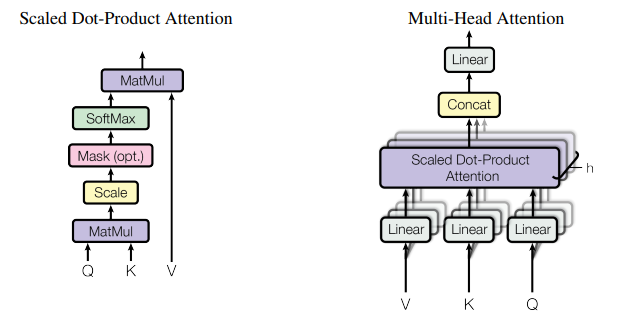

*Источник: Attention Is All You Need*

Также ниже представлена визуализация работы multi-head attention на текстовом примере, где разными цветами обозначены головы внимания:

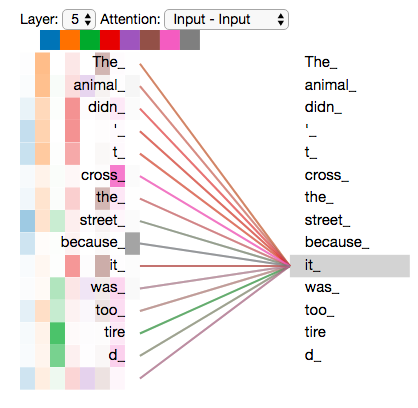

*Источник: The Illustrated Transformer*

Помимо того, что механизм внимания лишён основных недостатков RNN, он также пригоден для работы с различными типами данных, включая аудио, видео, изображения и так далее, что делает его универсальным. С другой стороны, его главный недостаток заключается в квадратичной сложности: $O(N^2d)$ по времени, $O(N^2)$ по пиковому потреблению памяти и $\Theta (Nd + N^2)$ по I/O сomplexity (количеству операций чтения/записи между разными уровнями памяти) относительно длины последовательности $N$, где $d$ — размерность эмбеддингов. Именно эти ограничения (особенное последние 2) привели к появлению более эффективных методов, таких как Flash Attention, который будет рассмотрен далее.

## **Что такое Flash Attention и почему это круто**

Изначально для решения вышеописанных проблем vanilla attention были предложены приближённые методы:

- Linformer: проецирование ключей и значений в пространство меньшей размерности.

- Performer: замена softmax на ядерные приближения через random features.

- Reformer: использование локального внимания и хеширования.

Их общая идея заключается в том, чтобы пожертвовать точностью ради линейной сложности. Эти методы действительно достигали $O(nd)$ или $O(n \log(n))$ сложности, но имели серьёзные компромиссы:

- вносили ошибки аппроксимации (погрешности), влияющие на качество моделей;

- требовали изменения архитектуры и переобучения моделей;

- зачастую плохо масштабировались на различных типах данных.

Немного позже был предложен другой подход: вместо изменения математики алгоритма — оптимизировать его реализацию под современные GPU. Ключевой инсайт пришёл из глубокого анализа профиля производительности vanilla attention.

### **Flash Attention 1: основная идея**

В работе (Tri Dao et al., 2022) было обнаружено, что vanilla attention ограничен не столько вычислительными ресурсами, сколько операциями доступа к памяти (I/O), а именно многократным обращением к HBM для чтения/записи $S = Q K^T$, $P = softmax(S)$ и $O = PV$, а также хранением $P$  для вычисления градиентов во время backward pass. В результате авторами данной работы был предложен алгоритм Flash Attention, позволяющий сократить число операций чтения/записи в HBM без аппроксимации результатов. Это достигается за счёт организации вычислений таким образом, чтобы промежуточные матрицы $S$ и $P$ хранились в SRAM, а в HBM записывался только конечный результат $O$ (выход внимания). В основе этого алгоритма лежат 3 фундаментальных принципа — разберём их более подробно.

**Kernel Fusion (слияние ядер)** — если к одним и тем же входным данным применяется несколько операций, то эти данные могут быть загружены из HBM один раз, а не несколько для каждой операции. Это означает, что все основные операции при вычислении attention объединяются в единый super-kernel, полностью избавляя от промежуточных обращений к HBM и многократных запусков ядер (kernels). Компиляторы могут автоматически объединять множество операций по элементам, однако в контексте обучения модели промежуточные значения по-прежнему необходимо записывать в HBM для сохранения при backward pass, что снижает эффективность наивного слияния ядер.

**Tiling (блочное разбиение)** — исходные матрицы Q, K, V разбиваются на блоки размером $2^n$ (обычно их размер не меньше 64), которые помещаются в SRAM. Вычисления происходят последовательно, причём каждый блок обрабатывается полностью перед переходом к следующему.



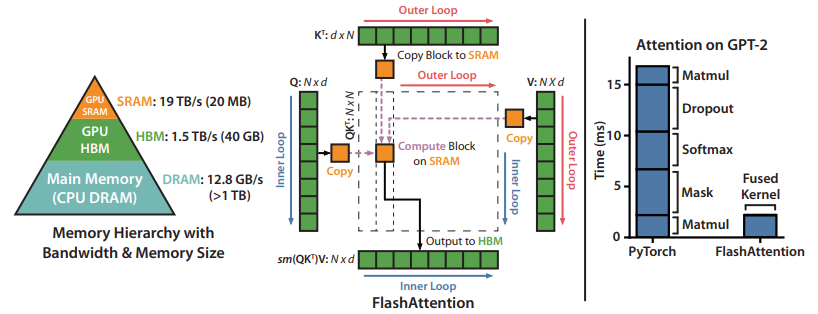

*Источник: FlashAttention paper*

**Online Softmax** — вместо вычисления softmax над всей матрицей $S$ одновременно, используется численно стабильный алгоритм, который обрабатывает матрицу блоками, аккумулируя статистики (максимумы и суммы) для корректной нормализации. Для простоты рассмотрим 1 строчный блок матрицы внимания $S$ вида $[S^{(1)}, S^{(2)}]$ для некоторых матриц $S^{(1)}, S^{(2)} \in \mathbb{R}^{B_r \times B_c}$, где $B_r$ и $B_c$ — размеры блоков по осям строк и столбцов соответственно. Нам необходимо вычислить softmax этого строчного блока и умножить на матрицу значений $V$ вида  $\begin{bmatrix} V^{(1)} \\ V^{(2)} \end{bmatrix}$ для некоторых матриц $V^{(1)}, V^{(2)} \in \mathbb{R}^{B_c \times d}$. Тогда стандартный softmax рассчитывается следующим образом:

$$
\hspace{2em} \begin{aligned}[l]
&m = \max(\text{rowmax}(S^{(1)}), \text{rowmax}(S^{(2)})) \in \mathbb{R}^{B_r}
\\
&\ell = \text{rowsum}(e^{S^{(1)} - m}) + \text{rowsum}(e^{S^{(2)} - m}) \in \mathbb{R}^{B_r}
\\
&P = \begin{bmatrix} P^{(1)} & P^{(2)} \end{bmatrix} = \text{diag}(\ell)^{-1} \begin{bmatrix} e^{S^{(1)} - m} & e^{S^{(2)} - m} \end{bmatrix} \in \mathbb{R}^{B_r \times 2B_c}
\\
&O = \begin{bmatrix} P^{(1)} & P^{(2)} \end{bmatrix} \begin{bmatrix} V^{(1)} \\ V^{(2)} \end{bmatrix} = \text{diag}(\ell)^{-1} \left( e^{S^{(1)} - m} V^{(1)} + e^{S^{(2)} - m} V^{(2)} \right) \in \mathbb{R}^{B_r \times d}
\end{aligned}
$$

Вместо этого online softmax вычисляет локальный softmax для каждого блока и изменяет масштаб, чтобы в конце получить правильный результат:

$$
\hspace{2em} \begin{aligned}[l]
&m^{(1)} = \text{rowmax}(S^{(1)}) \in \mathbb{R}^{B_r}
\\
&\ell^{(1)} = \text{rowsum}(e^{S^{(1)} - m^{(1)}}) \in \mathbb{R}^{B_r}
\\
&\tilde{P}^{(1)} = \text{diag}(\ell^{(1)})^{-1} e^{S^{(1)} - m^{(1)}} \in \mathbb{R}^{B_r \times B_c}
\\
&O^{(1)} = \tilde{P}^{(1)} V^{(1)} = \text{diag}(\ell^{(1)})^{-1} e^{S^{(1)} - m^{(1)}} V^{(1)} \in \mathbb{R}^{B_r \times d}
\\
&m^{(2)} = \max(m^{(1)}, \text{rowmax}(S^{(2)})) = m
\\
&\ell^{(2)} = e^{m^{(1)} - m^{(2)}} \ell^{(1)} + \text{rowsum}(e^{S^{(2)} - m^{(2)}}) = \text{rowsum}(e^{S^{(1)} - m}) + \text{rowsum}(e^{S^{(2)} - m}) = \ell
\\
&\tilde{P}^{(2)} = \text{diag}(\ell^{(2)})^{-1} e^{S^{(2)} - m^{(2)}}
\\
&O^{(2)} = \text{diag}(\ell^{(1)} / \ell^{(2)})^{-1} O^{(1)} + \tilde{P}^{(2)} V^{(2)} = \text{diag}(\ell^{(2)})^{-1} e^{S^{(1)} - m} V^{(1)} + \text{diag}(\ell^{(2)})^{-1} e^{S^{(2)} - m} V^{(2)} = O
\end{aligned}
$$

Данный процесс вычисления представлен на диаграмме ниже. Для простоты в ней опущен шаг, который вычитает каждый элемент на максимальное значение по строкам:

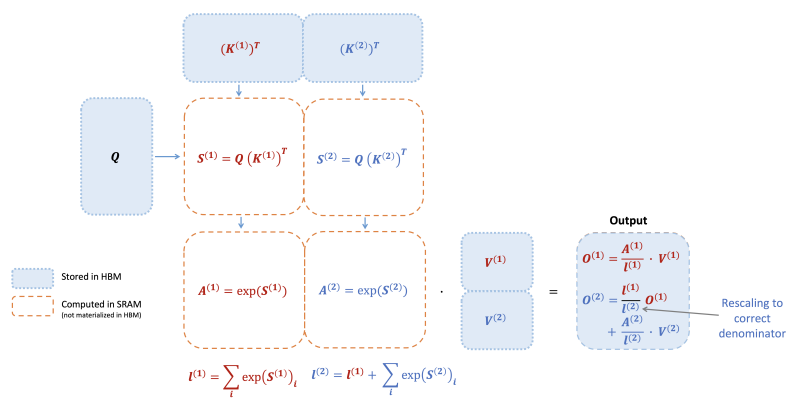

*Источник: FlashAttention-2 paper*

**Решение для backward pass**

Для стандартной реализации attention принцип работы backward pass выглядит следующим образом:

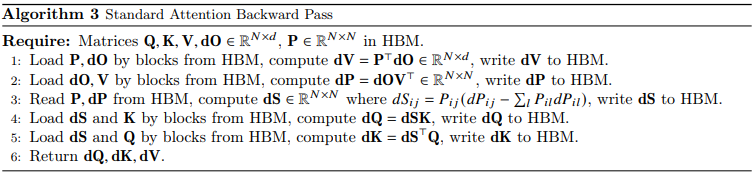

В случае же Flash Attention нет необходимости хранить промежуточные матрицы $S$ и $P$ для расчёта градиентов, поскольку блоки входных данных Q, K, V уже загружены в SRAM, где повторно будут вычислены $S$ и $P$, что снизит пиковое потребление памяти до $O(N)$. Помимо экономии памяти в 10-20 раз в зависимости от длины последовательности, такой подход также ускоряет работу алгоритма в 2-4 раза по времени. Хотя концептуально backward pass и кажется проще по сравнению с forward pass из-за отсутствия перемасштабирования softmax, данная реализация оказывается значительно сложнее. Это связано с тем, что в SRAM необходимо хранить больше значений для выполнения 5 матричных умножений вместо 2 в forward pass. В любом случае это снижает I/O-сложность до $\Theta ({N^2 d M^{-1}})$, что для типичных значений $d$ (64-128) and $M$ (размер SRAM) многократно снижает число обращений к HBM (до 9 раз).

**Block-sparse Flash Attention** расширяет оригинальный Flash Attention до приближённого варианта, вводя структурную разреженность на уровне блоков, что значительно сокращает расходы на хранение и вычисления при длинных контекстах. Вместо материали­зации полной матрицы внимания алгоритм выполняет все шаги только для заранее заданных, наиболее важных блоков, отмеченных в маске (1 — вычислить блок, 0 — пропустить). В итоге такой алгоритм работает быстрее любого из существующих методов приблизительного внимания.

**Экспериментальные результаты и практическая значимость**

Flash Attention продемонстрировал невероятные результаты производительности для трансформеров, а также позволил работать с ранее недоступными длинами последовательностей. При тестировании на 8xA100 GPU были получены следующие результаты:

- Ускорение на 15% обучения BERT-large на Wikipedia датасете относительно Nvidia MLPerf 1.1 при достижении target accuracy 72% за 17.4 минуты вместо 20.
- Ускорение обучения GPT-2 на датасете OpenWebtext в 3 раза относительно Hugging Face и в 1.7 раза относительно Megatron-LM. Для small моделей: 2.7 дня вместо 9.5 и 4.7 соответственно, medium: 6.9 вместо 21 и 11.5 соответственно. При этом GPT-2 small с Flash Attention при увеличенной длине последовательности до 4k по-прежнему работает на 30% быстрее и обеспечивает снижение perplexity (метрика качества языковых моделей) на 0.7 в сравнении с Megatron-LM 1k.
- Ускорение обучения в 2.4 раза на наборе задач Long-Range Arena (LRA) в сравнении с vanilla transformer.
- Flash Attention позволил трансформеру с точным (exact) механизмом внимания впервые превзойти случайный baseline на синтетической задаче Path-X (длина 16K токенов), а block-sparse Flash Attention — на Path-256 (длина 64K токенов). В этих тестах необходимо определить существует ли путь между двумя точками на черно-белом изображении размером 128x128 или 256x256. Основная сложность заключается в том, что изображение подаётся в модель по одному пикселю за раз, что создаёт сверхдлинные входные последовательности.

Хотя Flash Attention и обеспечивает значительное ускорение экспериментов с крупными моделями, его главное преимущество  заключается в сокращении затрат на всех этапах жизненного цикла — от прототипирования и обучения моделей до инференса в продакшене. Теперь для достижения аналогичных результатов требуется в 2–3 раза меньше GPU, что значительно снижает как издержки на развёртывание и поддержку проектов, так и порог входа для разработки и вывода продуктов на рынок. Иными словами, данный подход не только оптимизирует вычисления, но и существенно повышает экономическую эффективность решений на базе трансформеров. Именно поэтому Flash Attention так крут, и, как демонстрирует дальнейшее развитие области, его потенциал для оптимизации далеко не исчерпан.

### **Flash Attention 2: что нового**

Несмотря на значительный прирост эффективности по сравнению со стандартным механизмом внимания, в следующей работе (Tri Dao et al., 2023) анализ производительности показал, что Flash Attention по-прежнему далеко не так эффективен, как низкоуровневые примитивы вроде оптимизированных матричных умножений (GEMM). В частности forward pass достигает лишь 30-50% от теоретического максимума FLOPs/s на A100 GPU, а backward pass — 25-35%, в то время как для GEMM этот показатель составляет 80-90%. Это связано с неоптимальным распределением работы между различными блоками потоков и варпами на GPU, что приводит либо
к их низкой занятости, либо к ненужным операциям чтения/записи в shared memory. Рассмотрим за счёт каких улучшений были устранены данные недостатки.

**Обновлённый online-softmax**, направленный на снижение количества операций, не являющихся матричными умножениями (non-matmul FLOPs). Это стало возможным благодаря двум трюкам:
- 1. *Отложенное масштабирование выходного аккумулятора*. Вместо того чтобы масштабировать обе части обновления вывода на каждом шаге, поддерживается «не масштабированная» версия выходного аккумулятора. Масштабирование выполняется только один раз в самом конце цикла по всем блокам для получения правильного результата:

$$
\hspace{2em} \begin{aligned}[l]
&\tilde{O}^{(2)} = \text{diag}(\ell^{(1)})^{-1} {O}^{(1)} + e^{S^{(2)} - m^{(2)}} V^{(2)}
\\
&O^{(2)} = \text{diag}(\ell^{(2)})^{-1} \tilde{O}^{(2)} = O
\end{aligned}
$$

- 2. *Экономия памяти при backward pass*. Для корректного вычисления градиентов достаточно хранить один объединённый тензор logsumexp $L^{(j)} = m^{(j)} + \log(\ell^{(j)})$ вместо максимумов $m$ и сумм экспонент $\ell$.

Тогда в случае с 2 блоками как в примере с Flash Attention 1, модификация online-softmax будет выглядеть как:

$$
\hspace{2em} \begin{aligned}[l]
&m^{(1)} = \text{rowmax}(S^{(1)}) \in \mathbb{R}^{B_r} \\
&\ell^{(1)} = \text{rowsum}(e^{S^{(1)} - m^{(1)}}) \in \mathbb{R}^{B_r} \\
&\tilde{O}^{(1)} = e^{S^{(1)} - m^{(1)}} V^{(1)} \in \mathbb{R}^{B_r \times d} \\
&m^{(2)} = \max(m^{(1)}, \text{rowmax}(S^{(2)})) = m \\
&\ell^{(2)} = e^{m^{(1)} - m^{(2)}} \ell^{(1)} + \text{rowsum}(e^{S^{(2)} - m^{(2)}}) = \text{rowsum}(e^{S^{(1)} - m}) + \text{rowsum}(e^{S^{(2)} - m}) = \ell \\
&\tilde{P}^{(2)} = \text{diag}(\ell^{(2)})^{-1} e^{S^{(2)} - m^{(2)}} \\
&\tilde{O}^{(2)} = \text{diag}(e^{m^{(1)} - m^{(2)}})^{-1} \tilde{O}^{(1)} + e^{S^{(2)} - m^{(2)}} V^{(2)} = e^{S^{(1)} - m} V^{(1)} + e^{S^{(2)} - m} V^{(2)} \\
&O^{(2)} = \text{diag}(\ell^{(2)})^{-1} \tilde{O}^{(2)} = O
\end{aligned}
$$

**Дополнительный параллелизм по длине последовательности**, что в случае её большой длины позволяет значительно ускорить работу алгоритма за счёт более высокой загрузки мультипроцессоров (SM). Это реализовано в 2 местах:

- В forward pass это достигается за счёт внешнего цикла (по длине последовательности), где каждый блок данных Q будет выполняться в своём thread блоке независимо.
- В backward pass тоже используется распараллеливание по длине последовательности во внешнем цикле, но не по блокам строк Q как в forward, а по блокам столбцов K/V, каждый из которых также будет выполняться в своём thread блоке независимо. Чтобы исключить состояние гонки (race condition) из-за одновременной записи частичных сумм в $dQ_i$ из разных thread-блоков, используется атомарная операция *atomic-add*, обеспечивающая корректность вычислений без потерь данных.





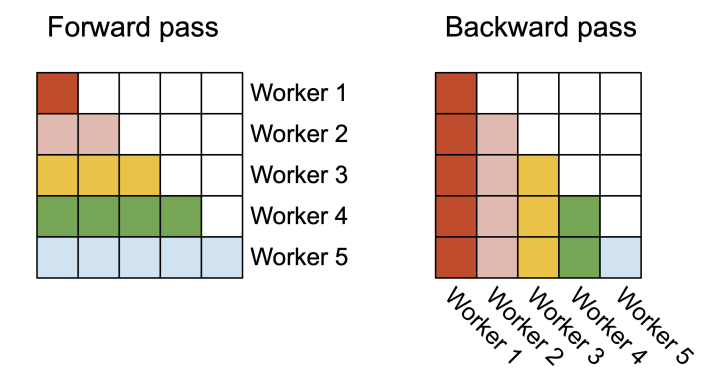

*Источник: FlashAttention-2 paper*

Атомарные операции — это низкоуровневые инструкции процессора, которые гарантируют выполнение определённой операции над ячейкой памяти как единой неделимой транзакции, исключая таким образом возможность перезаписи результатов другими потоками. Однако, стоит иметь в виду, что использование таких операций не обеспечивает детерминизм (воспроизводимость результатов даже при фиксированном random seed), поскольку в них не учитывается порядок выполнения между разными thread-блоками. В случае, когда детерминизм необходим, этот режим следует сделать опциональным, также добавив последовательную обработку блоков столбцов K/V, но в таком случае производительность снизится на 10-20%.

**Эффективное разделение работы между варпами (warps)**, направленное на минимизацию операций чтения/записи в shared memory, также реализовано в 2 местах:

- В forward pass вместо использования схемы «split-K» (когда для каждого блока $K$ и $V$ работа распределялась между 4 варпами, в то время как $Q$ оставался доступным для всех варпов) было предложено разделять $Q$ между 4 варпами, а $K$ и $V$ оставить доступными для всех варпов:



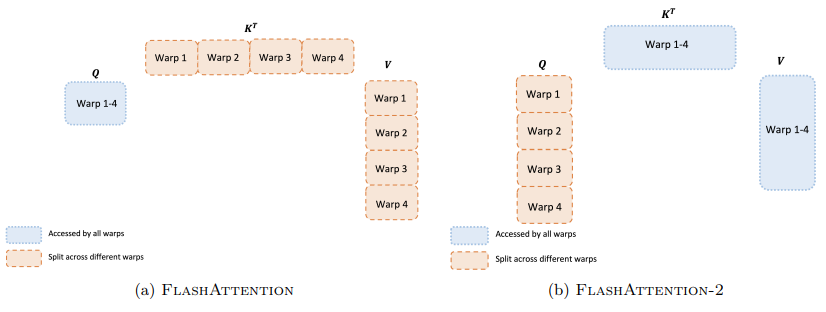

*Источник: FlashAttention-2 paper*



- В backward pass применяется аналогичная схема, однако это всё ещё требует некоторой синхронизации из-за более сложной зависимости между всеми различными входными данными и градиентами $Q$, $K$, $V$, $O$, $dO$, $dQ$, $dK$, $dV$. Тем не менее, даже в таком случае объём операций с shared memory значительно сокращается по сравнению с первоначальным подходом.

**Полный принцип работы Flash Attention 2**:

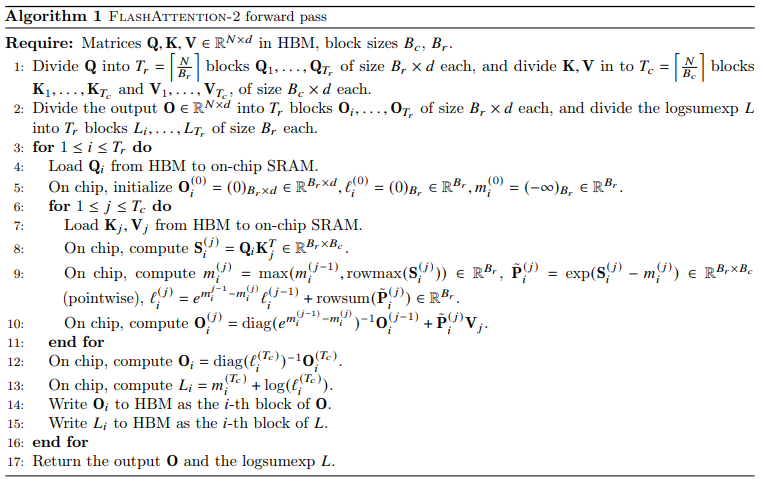

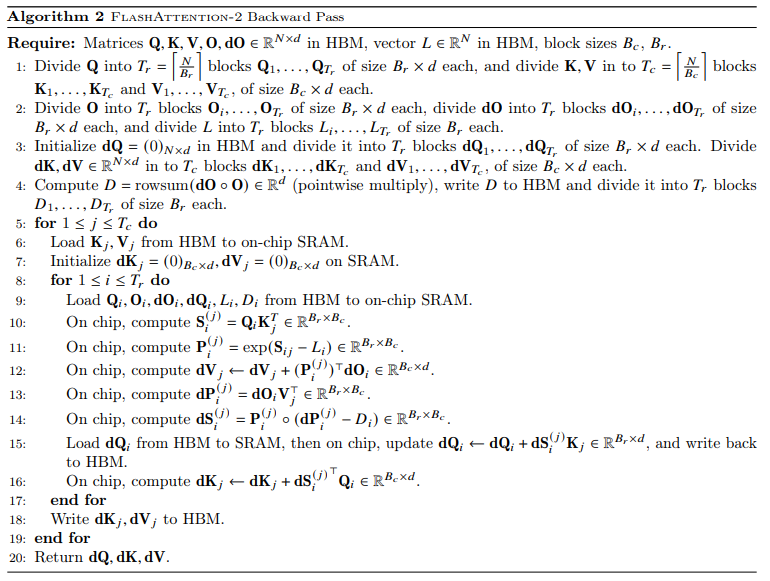

**Ключевые результаты производительности**

При тестировании Flash Attention 2 на том же оборудовании, что и Flash Attentiion 1, были получены следующие результаты:
- Скорость работы ядра (Kernel Speed) увеличилась примерно в 2 раза.
- Пиковая вычислительная мощность достигает 230 TFLOPs/s на A100, что составляет 73% от теоретического максимума для этого чипа.
- При обучении GPT моделей (1.3B и 2.7B параметров) на последовательностях длиной 2k и 8k токенов, использование Flash Attention 2 даёт 1.3-кратное ускорение по сравнению с Flash Attention 1 и 2.8-кратное ускорение относительно базового варианта без Flash Attention. Было достигнуто 225 TFLOPs/s на один GPU A100 (72% model FLOPs utilization).

Поскольку Flash Attention 2 в среднем работает вдвое быстрее своей предыдущей версии, на практике это означает снижение стоимости обучения моделей с длиной контекста 16K до уровня, соответствующего прежним 8K. Проще говоря, это открывает доступ к моделям с удвоенной длиной контекста за те же деньги, что и раньше.


### **Пару слов про Flash Attention 3**

Хотя Flash Attention 2 показал хорошие результаты на A100, для более новых архитектур (Hopper и выше) он обеспечивает низкую загрузку GPU (utilization), достигая лишь 35% от теоретического максимума на H100, в то время как для GEMM этот показатель составляет 80-90%. Поэтому Flash Attention 3 можно рассматривать как адаптацию 2 версии под новые архитектуры, что значительно раскрывает их потенциал, обеспечивая в итоге прирост скорости в 1.5-2 раза и загрузку до 75% на H100, а также работу с гораздо более длинными последовательностями. Это стало возможным благодаря трём нововведениям:

- **Использование асинхронности Tensor Cores и TMA**. Архитектура Hopper позволяет независимо и параллельно выполнять операции вычислений на Tensor Cores и перемещения данных через Tensor Memory Accelerator (TMA). Для этого используется warp-специализация, где одни группы потоков (warps) отвечают за загрузку данных через TMA, а другие — за матричные умножения через WGMMA, что обеспечивает их эффективное перекрытие.

- **Перекрытие операций GEMM и Softmax**. Поскольку пропускная способность H100 для специальных функций (например, экспоненты для softmax) составляет приблизительно 3.9 TFLOPS, что в 256 раз меньше чем для матричных операций в FP16, то для скрытия задержек softmax используется техника *ping-pong scheduling*, в основе которой лежит синхронизация барьеров, необходимая для принудительного планирования запуска одной warp группы раньше, чем другой. В итоге это повышает производительность на 10-15%. Более того, похожий подход можно применить в рамках одной warp группы, что даст ещё небольшой прирост производительности.

- **Эффективная работа с низкой точностью (FP8)**. Использование формата FP8 позволяет практически удвоить пропускную способность Tensor Cores, но создаёт проблему высокой ошибки квантования, особенно из-за выбросов в активациях LLM. Для решения данной проблемы применяются две ключевых техники:
  - *Блочное квантование*. Вместо использования одного масштаба для всего тензора, для каждого отдельного блока данных вычисляется свой собственный масштаб, что значительно повышает точность.
  - *Incoherent Processing*. Перед квантованием тензоры Q и K умножаются на случайную ортогональную матрицу (преобразование Адамара (Hadamard)), которая позволяет равномерно распределить выбросы по всем элементам. Это преобразование не меняет результат внимания, но снижает ошибку квантования в 2.6 раза по сравнению с базовой реализацией FP8, позволяя достичь почти 1.2 PFLOPS/s на H100.

Как можно заметить, ключевые оптимизации Flash Attention 3 касаются исключительно последних архитектур GPU, а создание единого высокопроизводительного и легко расширяемого решения сразу для всего семейства архитектур от Turing до Blackwell сопряжено со значительными трудностями в реализации. Именно поэтому я остановился на реализации Flash Attention 2 как наиболее универсального и надёжного варианта для продакшена. Возможно в будущем я сделаю отдельную реализацию Flash Attention 3 с её более подробным описанием, но пока что это не точно.

## **Почему Triton, а не CUDA**

Начнём с того, что **CUDA (Compute Unified Device Architecture)** — это низкоуровневый фреймворк от NVIDIA, который уже давно является промышленным стандартом для написания GPU-ускорителей. По сути, это тот же C++ с расширениями, где разработчикам необходимо вручную управлять памятью, потоками и использованием shared memory. Хотя это и даёт максимальный контроль, но написание эффективных ядер (kernels) превращается в сложную и трудоёмкую задачу, требующую глубоких знаний о конкретной архитектуре GPU, не говоря уже про умение писать на C++.

**Triton**, в свою очередь — это специализированный язык для написания вычислительных ядер (kernels) DNN от OpenAI, также обеспечивающий работу с максимальной производительностью на современных GPU, но с интерфейсом в Python стиле. Triton имеет собственный JIT-компилятор, который автоматически занимается многими низкоуровневыми оптимизациями, за которые в CUDA приходится отвечать разработчику самостоятельно. Triton-код в несколько раз короче и нагляднее своего CUDA-аналога, поскольку абстракции вроде блочных операций (tl.dot) и автоматического управления памятью позволяют сосредоточиться на логике алгоритма (например, tiling или online softmax), а не на рутинном низкоуровневом коде. Хотя использование Triton заметно упрощает разработку и обеспечивает близкую к CUDA производительность, у него есть несколько ограничений:

- Это относительно новый проект с менее развитым сообществом и количеством обучающих материалов по сравнению с CUDA.
- Ограниченная интеграция с профайлерами и отладчиками Nvidia (Nsight), что усложняет глубокую диагностику узких мест в ядрах.
- Возможны трудности с интеграцией в существующие проекты, построенные на специфичных CUDA-библиотеках.
- В чистом виде не поддерживает работу на Windows.

Нужно понимать, что Triton не является универсальной заменой CUDA, а скорее мощным специализированным инструментом в конкретной области. Конкретно в случае с Flash Attention это означает практически сопоставимую с CUDA производительность при значительно меньшем количестве кода: ~800-1200 строк вместо ~3000-5000 в зависимости от способа реализации. В итоге это делает разработку и поддержку высокопроизводительного кода значительно проще, и именно поэтому я использовал Triton для реализации Flash Attention 2.


## **Обзор ключевых особенностей реализации**

Для начала рассмотрим популярные реализации Flash Attention 2: Dao AI Lab (CUDA, Triton), Pytorch (CUDA) и OpenAI (Triton). Они имеет следующие ограничения:

- Ограниченная поддержка аппаратных архитектур. Все они работают исключительно с архитектурами Ampere и новее, исключая поддержку широко распространённых GPU Turing (T4, RTX 20-й серии), что критично для работы в Google Colab и Kaggle.

- Отсутствие ручной кастомизации ядер (kernels). Ни одна из перечисленных реализаций не предоставляет возможность ручной настройки вычислительных ядер под конкретные характеристики GPU, что на практике оказывается очень полезным, так как специализированная оптимизация может обеспечить заметный прирост производительности.

- Поддержка опционального детерминизма «из коробки». Явный и документированный контроль над детерминизмом результатов доступен только в CUDA-реализации Dao AI Lab. В реализации PyTorch для достижения такого поведения требуется синхронизация потоков через torch.cuda.synchronize, хотя об этом нигде не заявлено в официальной документации или туториалах.

- Проблемы стабильности Triton. Помимо работы только на Linux, в версиях Triton 3.3.0 и выше есть баг, связанный с увеличенным потреблением shared memory. Это особенно заметно на старых архитектурах (Turing и Ampere) с ранее работоспособными конфигурациями: блоки, ранее помещавшиеся в память, теперь вызывают её переполнение. При этом поддержка архитектуры Blackwell требует именно этих проблемных версий Triton, создавая дополнительный конфликт совместимости между новейшими и устаревающими архитектурами.

- Неопределённость работы в гетерогенных средах. Отсутствует информация по работе в кластерах со смешанными архитектурами GPU, что создаёт риски при распределённом обучении на разнородном оборудовании.

- Низкое качество кода и сложность его поддержки. Во всех рассмотренных реализациях используется код с неинформативными названиями переменных (например, N_CTX, off_m, l_ij, start_n), минимальным количеством комментариев и практически полным отсутствием документации (docstrings). В итоге это значительно затрудняет понимание алгоритма новыми разработчиками, усложняет отладку и дальнейшее сопровождение кодовой базы.

Именно с учётом перечисленных выше ограничений я разработал реализацию Flash Attention 2 на Triton, призванную предложить универсальное, удобное и более гибкое решение для разработчиков. Ниже описаны её ключевые особенности и подходы к их реализации.

- **Поддержка архитектур Turing и выше**. Ранее считалось, что Flash Attention не способен работать с Turing GPU, но в ходе тестов на T4 были эмпирически подобраны оптимальные размеры блоков, позволяющие уместить их в shared memory. В legacy режиме (Triton ≤3.2.0) используются блоки 128x128 для forward и 64x64 для backward pass. В modern режиме (Triton ≥3.3.0) применяется асимметричная конфигурация 128x32 для forward и 32x32 для backward при том, что для обоих режимов max_headdim составляет 128. Для более новых архитектур используются блоки большего размера и большее число варпов, а необходимая конфигурация с оптимальными параметрами выбирается автоматически в зависимости от архитектуры GPU и версии Triton через интерфейс flash_attention_v2. Также стоит иметь в виду, что для modern режима (из-за бага с shared memory в Triton ≥3.3.0) производительность на Turing падает до уровня vanilla attention, при этом на Ampere-Hopper она также немного снижается, поэтому в таком случае лучше использовать legacy режим через pip install flash-attention-triton[legacy]. Если же в вашей сборке имеется Blackwell GPU, необходимо использовать только modern режим. Интересный факт: при использовании T4 на triton==3.2.0 прирост скорости обучения ощущается даже на последовательности в 1 тысячу токенов — 135 секунд вместо 180 в сравнении с vanilla attention.

- **Возможность ручной кастомизации ядер (kernels)**. Для сценариев, требующих максимальной производительности на специфичном оборудовании, реализация предоставляет расширенный интерфейс flash_attention_v2_custom, который позволяет вручную настроить параметры ядер для конкретных архитектур GPU через конфигурационный словарь kernels_configs, где ключ — это compute capability конкретной архитектуры, а значение — специальный объект KernelsConfigV2, содержащий в себе информацию о размерах блоков, количестве варпов, конфигурацию Triton автотюнера для backward pass и так далее. Например, для Ampere+ архитектур можно установить размер блоков 256x256 с 16 варпами, а для Turing — 128x128 с 8 варпами. Это может быть особенно полезно для продвинутой оптимизации и исследований, когда автоматических настроек недостаточно.

- **Контроль детерминизма на уровне API**. Интерфейс flash_attention_v2 поддерживает флаг deterministic=True, гарантирующий воспроизводимость результатов при заданном seed независимо от количества повторных запусков алгоритма. Такое поведение достигается за счёт использования последовательной обработки блоков вместо атомарных операций в backward pass. Хотя это критически важно для отладки и проведения экспериментов, стоит иметь в виду, что использование данного режима приводит к снижению производительности на 10-20% на длинных последовательностях, поэтому для продакшен-сценариев, где детерминизм не важен, рекомендуется использовать флаг deterministic=False.

- **Кроссплатформенная поддержка**. Реализация обеспечивает стабильную работу на разных операционных системах благодаря их автоматическому определению и установке соответствующих пакетов: triton для Linux и triton-windows для Windows, однако, стоит иметь в виду, что для корректной работы на Windows требуется Microsoft Visual C++ Redistributable версии 14.42 или выше. При использовании более старых версий необходимо обновить распространяемые компоненты, скачав их с официального сайта [Microsoft](https://learn.microsoft.com/en-us/cpp/windows/latest-supported-vc-redist?view=msvc-170), после чего скопировать файлы msvcp140.dll, vcruntime140.dll и vcruntime140_1.dll из системной директории C:\Windows\System32\ в папку с установленным Python. В случае возникновения других проблем по работе Triton на Windows рекомендуется ознакомиться с их решением в репозитории [triton-windows](https://github.com/woct0rdho/triton-windows).

- **Поддержка гетерогенных GPU кластеров**. Глобальный кэш _BACKWARD_KERNEL_CACHE хранит скомпилированные ядра для каждой комбинации compute capability и конфигурации KernelsConfig, что исключает повторную JIT-компиляцию при работе с разными архитектурами. При этом важно учитывать, что нативное распределённое обучение в Pytorch с разнородными GPU имеет субоптимальную эффективность из-за различающихся аппаратных характеристик, прежде всего из-за разных объёмов памяти на различных уровнях и пропускной способности. В связи с этим при обучении трансформеров в таких средах требуются дополнительные стратегии: ручная балансировка нагрузки либо применение специализированных решений, таких как Pipeline Parallelism из PyTorch, DeepSpeed или исследовательских подходов типа CEPHALO (Benson Guo, et al.), HetSeq (Ding, et al.) и так далее.

- **Более высокое качество кода**. В коде используются семантически явные названия переменных, а каждая функция снабжена подробными docstring и развёрнутыми комментариями там, где это необходимо. Также был реализован удобный интерфейс для создания конфигов под каждую GPU архитектуру и с автоматическом выбором заранее установленных конфигураций в зависимости от версии Triton. В итоге всё это значительно снижает порог входа для новых разработчиков и упрощает модификацию алгоритма под специфические требования.

Для использования Flash Attention 2 на Triton достаточно сделать pip install flash-attention-triton[modern] или pip install flash-attention-triton[legacy] в зависимости от задач и используемых GPU архитектур, а входные тензоры должны иметь форму (batch, nheads, seqlen_q, headdim). Ниже приведены иллюстративные примеры использования Flash Attention 2 в разных режимах.

**flash_attention_v2** — авторежим




In [ ]:
import torch
from flash_attention_triton import flash_attention_v2


# Input tensors: (batch, n_heads, seq_len, head_dim)
q = torch.randn(16, 8, 512, 64, device="cuda")
k = torch.randn(16, 8, 512, 64, device="cuda")
v = torch.randn(16, 8, 512, 64, device="cuda")

# Automatic mode — hardware optimized
output = flash_attention_v2(q, k, v, softmax_scale=None, deterministic=True)

**flash_attention_v2_custom** — кастомный режим (пример приведён на конфиге для одной архитектуры GPU, но словарь non_deterministic_configs может содержать внутри себя несколько конфигов при передаче в параметр kernels_configs)

In [ ]:
import torch
import triton
from flash_attention_triton import KernelsConfigV2, flash_attention_v2_custom, init_to_zero_v2


# Input tensors: (batch, n_heads, seq_len, head_dim)
q = torch.randn(16, 8, 512, 64, device="cuda")
k = torch.randn(16, 8, 512, 64, device="cuda")
v = torch.randn(16, 8, 512, 64, device="cuda")

turing_backward_autotune_config_non_deterministic = [
    triton.Config(
        {"BLOCK_Q_ROWS_SIZE": 64, "BLOCK_KV_COLS_SIZE": 64, "SEQUENCE_PARALLEL": False},
        num_warps=4,
        num_stages=1,
        pre_hook=init_to_zero_v2("DQ"),
    ),
    triton.Config(
        {"BLOCK_Q_ROWS_SIZE": 64, "BLOCK_KV_COLS_SIZE": 64, "SEQUENCE_PARALLEL": True},
        num_warps=4,
        num_stages=1,
        pre_hook=init_to_zero_v2("DQ"),
    ),
]
turing_kernel_config_non_deterministic = KernelsConfigV2(
    block_rows_size=128,
    block_cols_size=128,
    min_block_headdim=16,
    max_headdim=128,
    seqlen_cache_divisor=32,
    min_warps=4,
    max_warps=8,
    num_stages=1,
    backward_autotune_configs=turing_backward_autotune_config_non_deterministic,
)

# Create configuration mapping (several configs may be added here)
non_deterministic_configs = {
    (7, 5): turing_kernel_config_non_deterministic,  # Turing GPUs (T4, RTX 20-series)
}

output = flash_attention_v2_custom(
    q, k, v, softmax_scale=None, kernels_configs=non_deterministic_configs
)

Теперь при разработке новой архитектуры с нуля (например, GPT), чтобы получить значительное ускорение во время обучения и инференса модели даже на старых GPU, достаточно вызвать одну из соответствующих функций с необходимыми тензорами и конфигурациями.

## **The end**

Представленная реализация Flash Attention 2 на Triton значительно упрощает доступ к высокопроизводительным вычислениям для задач внимания, устраняя ключевые проблемы существующих решений. Данный проект представляет особую ценность не только для исследователей и инженеров, но и для студентов благодаря возможности работать в Google Colab и Kaggle, а подробный туториал с описанием принципа работы механизма внимания и его эволюции в различные версии Flash Attention позволит значительно быстрее погрузиться в тему как ML разработчикам, так и всем, кому просто интересна тема LLM и AI в целом.

Хочу выразить особую благодарность Tri Dao и его команде за разработку такой выдающейся концепции, разработчикам Triton за инструмент, позволивший заметно упростить написание кода, а также своему брату Максиму за помощь в тестировании. Пока что это самый технически сложный и крутой open-source проект в моей практике, в который было вложено много времени и усилий, поэтому мне будет очень приятно узнать, если данный проект найдёт применение в продакшене или окажется полезен в образовательных целях.

Что будет дальше? Дальше будет ещё круче: серия статей и видео в похожем стиле с реализацией ChatGPT (а если быть точнее, то чего-то очень на него похожего концептуально) с полного нуля от токенизатора до RLHF. Также в дальнейшем планируется сделать туториалы по реализации с нуля Suno, Sora и подобия AGI, но до этого пока что далеко.

**Всем успехов и до новых встреч!**



## **Дополнительные источники**

Статьи:

- [«Recurrent Neural Networks (RNNs): A gentle Introduction and Overview»](https://arxiv.org/abs/1912.05911), Robin M. Schmidt;

- [«Neural Machine Translation by Jointly Learning to Align and Translate»](https://arxiv.org/abs/1409.0473), Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio;

- [«Memory Networks»](https://arxiv.org/abs/1410.3916), Jason Weston, Sumit Chopra, Antoine Bordes;

- [«Effective Approaches to Attention-based Neural Machine Translation»](https://arxiv.org/abs/1508.04025), Minh-Thang Luong, Hieu Pham, Christopher D. Manning;

- [«A Structured Self-attentive Sentence Embedding»](https://arxiv.org/abs/1703.03130), Zhouhan Lin, Minwei Feng, Cicero Nogueira dos Santos, Mo Yu, Bing Xiang, Bowen Zhou, Yoshua Bengio;

- [«Attention Is All You Need»](https://arxiv.org/abs/1706.03762v7), Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin;

- [«FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness»](https://arxiv.org/abs/2205.14135), Tri Dao, Daniel Y. Fu, Stefano Ermon, Atri Rudra, Christopher Ré;

- [«FlashAttention-2: Faster Attention with Better Parallelism and Work Partitioning»](https://arxiv.org/abs/2307.08691), Tri Dao;

- [«FlashAttention-3: Fast and Accurate Attention with Asynchrony and Low-precision»](https://arxiv.org/abs/2407.08608), Jay Shah, Ganesh Bikshandi, Ying Zhang, Vijay Thakkar, Pradeep Ramani, Tri Dao;

- [«Triton: An Intermediate Language and Compiler for Tiled Neural Network Computations»](https://www.eecs.harvard.edu/~htk/publication/2019-mapl-tillet-kung-cox.pdf), Philippe Tillet, H. T. Kung, David Cox;

- [«HetSeq: Distributed GPU Training on Heterogeneous Infrastructure»](https://arxiv.org/abs/2009.14783), Yifan Ding, Nicholas Botzer, Tim Weninger.

- [«Cephalo: Harnessing Heterogeneous GPU Clusters for Training Transformer Models»](https://arxiv.org/abs/2411.01075), Runsheng Benson Guo, Utkarsh Anand, Arthur Chen, Khuzaima Daudjee.

Документация:
- [Triton](https://triton-lang.org/main/);
- [PyTorch](https://pytorch.org/).
